In [1]:
import pandas as pd
from google.cloud import storage
import os

In [2]:
# Establecer la ruta del archivo de credenciales
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../cloud/proyecto2-462217-118002bf0caf.json"

In [3]:
bucket_name = "mi-bucket-heartdata"
blob_path = "data/clean_heart-disease-dataset.csv"
file_path = f"gs://{bucket_name}/{blob_path}"

In [4]:
df = pd.read_csv(file_path)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import itertools
import numpy as np

Data Augmentation

In [8]:
# --- Separar características y target ---
X = df.drop('target', axis=1)
y = df['target']

In [9]:
# --- Aplicar SMOTE para balancear ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Antes SMOTE, clases: \n{y.value_counts()}")
print(f"Después SMOTE, clases: \n{pd.Series(y_resampled).value_counts()}")

Antes SMOTE, clases: 
target
0.0    388
1.0    355
Name: count, dtype: int64
Después SMOTE, clases: 
target
0.0    388
1.0    388
Name: count, dtype: int64


In [10]:
# --- Definir modelo ---
model = RandomForestClassifier(random_state=42)

In [11]:
# --- Validación cruzada estratificada ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# --- Predicciones con cross_val_predict para evaluar ---
y_pred = cross_val_predict(model, X_resampled, y_resampled, cv=cv)

In [13]:
# --- Métricas ---
print("Reporte de clasificación:\n")
print(classification_report(y_resampled, y_pred))

Reporte de clasificación:

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86       388
         1.0       0.86      0.87      0.87       388

    accuracy                           0.86       776
   macro avg       0.86      0.86      0.86       776
weighted avg       0.86      0.86      0.86       776



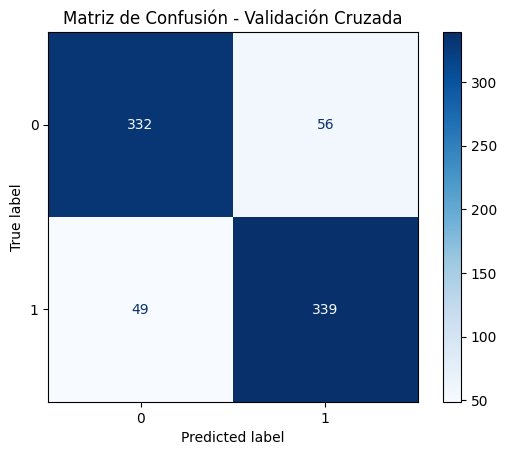

In [15]:
# Matriz de confusión — etiquetas fijas (0 y 1)
cm = confusion_matrix(y_resampled, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Validación Cruzada")
plt.show()

Entrenamiento de modelo Random Forest Classifier

In [34]:
# --- Definición del grid de hiperparámetros ---
param_grid = {
    'n_estimators': [10, 20, 50, 70, 100, 125, 150, 175, 200, 250],
    'max_depth': [1, 3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 3, 5, 8, 10]
}

In [35]:
# Para guardar resultados
results = []

In [37]:
# --- Función para detectar overfitting/underfitting ---
def evaluar_fit(acc_train, acc_val, delta_threshold=0.1):
    """
    acc_train: accuracy en entrenamiento
    acc_val: accuracy en validación
    delta_threshold: diferencia umbral para detectar over/underfitting
    
    Retorna: string indicando fit
    """
    delta = acc_train - acc_val
    if acc_train < 0.6 and acc_val < 0.6:
        return "Underfitting: bajo desempeño en train y validación"
    elif delta > delta_threshold:
        return "Overfitting: buen desempeño en train, malo en validación"
    else:
        return "Buen ajuste: desempeño similar en train y validación"

In [38]:
# --- División para medir overfitting: train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [39]:
# --- Búsqueda manual con itertools ---
for n_estimators, max_depth, min_samples_split in itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split']
):
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    # Entrenar y evaluar en train
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    
    # Validación cruzada en train para evaluar generalización
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    val_acc = val_scores.mean()
    
    results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'fit_evaluation': evaluar_fit(train_acc, val_acc)
    })

In [40]:
# --- Elegir mejor modelo por mejor val_accuracy ---
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['val_accuracy'].idxmax()]
print("Mejores hiperparámetros encontrados:")
print(best_row)

Mejores hiperparámetros encontrados:
n_estimators                                                        50
max_depth                                                          7.0
min_samples_split                                                    5
train_accuracy                                                0.946774
val_accuracy                                                   0.86129
fit_evaluation       Buen ajuste: desempeño similar en train y vali...
Name: 87, dtype: object


In [41]:
# --- Entrenar modelo final con mejores hiperparámetros ---
best_model = RandomForestClassifier(
    n_estimators=best_row['n_estimators'],
    max_depth=best_row['max_depth'].astype(int),
    min_samples_split=best_row['min_samples_split'],
    random_state=42
)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_split=5, n_estimators=50,
                       random_state=42)

In [42]:
# --- Evaluar en test ---
y_test_pred = best_model.predict(X_test)
print("\nReporte en test set:")
print(classification_report(y_test, y_test_pred))


Reporte en test set:
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91        78
         1.0       0.94      0.86      0.90        78

    accuracy                           0.90       156
   macro avg       0.91      0.90      0.90       156
weighted avg       0.91      0.90      0.90       156



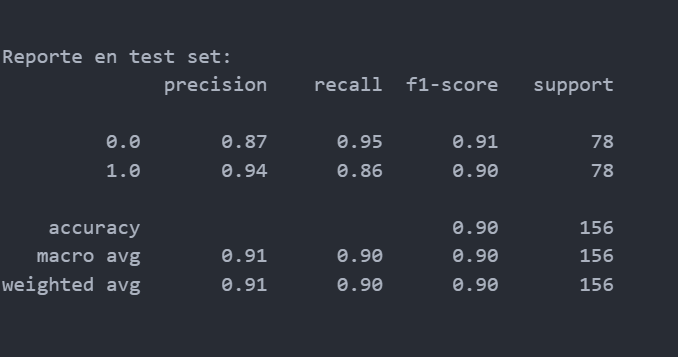

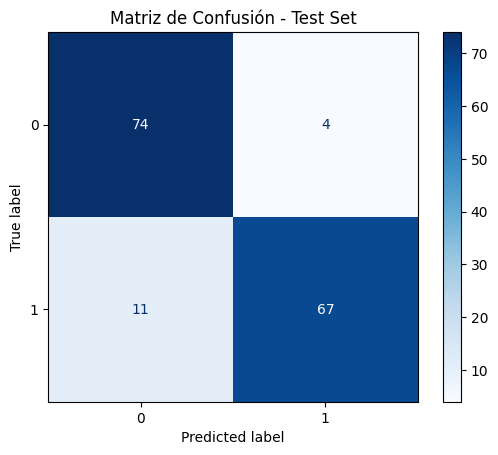

In [43]:
# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Test Set")
plt.show()

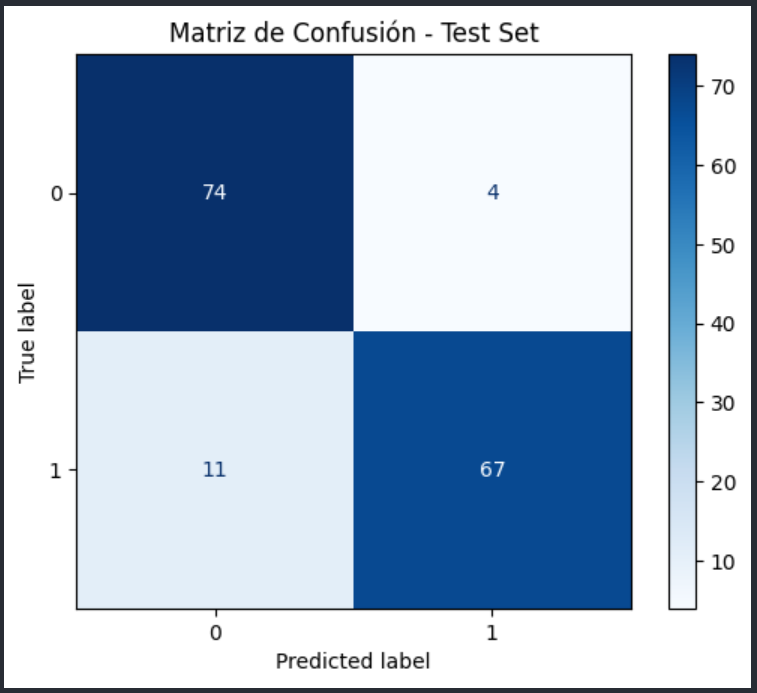

In [ ]:
# --- Evaluar fit en test ---
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Accuracy en test: {test_acc:.3f}")
print("Evaluación fit en test:", evaluar_fit(best_row['train_accuracy'], test_acc))

Accuracy en test: 0.904
Evaluación fit en test: Buen ajuste: desempeño similar en train y validación


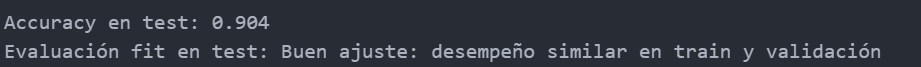

Uso de CTGAN para incrementar el numero de datos de entrenamiento

In [79]:
from ctgan import CTGAN

In [80]:
categorical_columns = [
    'sex',
    'chest_pain_type',
    'fasting_blood_sugar',
    'resting_ecg',
    'exercise_angina',
    'st_slope',
    'target'  # si quieres generar datos con target también categórico
]

In [81]:
# Supongamos que tu dataframe original es df_clean
ctgan = CTGAN(epochs=10)
ctgan.fit(df, discrete_columns=categorical_columns)

# Generar 500 filas sintéticas
synthetic_data = ctgan.sample(500)

In [82]:
synthetic_data.shape

(500, 12)

In [83]:
synthetic_data.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
0,44.489251,1.0,4.0,126.080712,261.814308,1.0,2.0,157.975105,0.0,1.691060,1.0,1.0
1,51.014565,0.0,4.0,134.838069,372.436077,1.0,2.0,102.000746,0.0,1.694427,0.0,0.0
2,26.481416,1.0,4.0,127.443221,355.778463,1.0,1.0,135.636262,0.0,2.767889,1.0,0.0
3,38.471269,1.0,2.0,128.024219,330.636106,1.0,1.0,93.046119,0.0,0.779023,2.0,0.0
4,32.541846,0.0,1.0,133.243565,277.673731,0.0,1.0,172.634269,0.0,0.035160,2.0,0.0


In [84]:
synthetic_data.describe()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,46.080717,0.568000,2.596000,134.190526,356.714900,0.380000,1.052000,110.412888,0.450000,1.357848,1.604000,0.462000
std,11.560846,0.495851,1.082186,21.283626,118.786857,0.485873,0.833478,26.469751,0.497992,1.476136,0.965945,0.499053
min,20.147564,0.000000,1.000000,88.942771,96.690955,0.000000,0.000000,54.795516,0.000000,-0.295029,0.000000,0.000000
25%,37.936634,0.000000,2.000000,122.025804,277.704687,0.000000,0.000000,91.864530,0.000000,0.129366,1.000000,0.000000
50%,45.493517,1.000000,3.000000,131.143716,337.787435,0.000000,1.000000,107.439630,0.000000,0.994360,1.000000,0.000000
75%,53.661399,1.000000,4.000000,143.344042,394.543530,1.000000,2.000000,127.388217,1.000000,2.127615,2.000000,1.000000
max,79.564019,1.000000,4.000000,218.339404,742.627309,1.000000,2.000000,200.092692,1.000000,5.888218,3.000000,1.000000


In [85]:
synthetic_data = pd.concat([synthetic_data, df], ignore_index=True)

In [86]:
synthetic_data.describe()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000
mean,50.150731,0.680611,2.934031,133.489351,289.980249,0.253419,0.804505,128.219987,0.411907,1.082401,1.593725,0.471440
std,10.896086,0.466427,1.045884,18.991976,103.614363,0.435144,0.860427,29.251854,0.492376,1.262103,0.767617,0.499385
min,20.147564,0.000000,1.000000,88.942771,96.690955,0.000000,0.000000,54.795516,0.000000,-0.295029,0.000000,0.000000
25%,42.316708,0.000000,2.000000,120.000000,221.000000,0.000000,0.000000,106.716330,0.000000,0.000000,1.000000,0.000000
50%,51.000000,1.000000,3.000000,130.000000,268.000000,0.000000,1.000000,128.000000,0.000000,0.771314,2.000000,0.000000
75%,58.000000,1.000000,4.000000,141.935474,331.656343,1.000000,2.000000,150.000000,1.000000,1.806688,2.000000,1.000000
max,79.564019,1.000000,4.000000,218.339404,742.627309,1.000000,2.000000,202.000000,1.000000,5.888218,3.000000,1.000000


In [91]:
# --- Definición del grid de hiperparámetros ---
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [1, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# Para guardar resultados
results = []

# --- Separar características y target ---
X = synthetic_data.drop('target', axis=1)
y = synthetic_data['target']
# --- División para medir overfitting: train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [92]:
# --- Búsqueda manual con itertools ---
for n_estimators, max_depth, min_samples_split in itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split']
):
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    # Entrenar y evaluar en train
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    
    # Validación cruzada en train para evaluar generalización
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    val_acc = val_scores.mean()
    
    results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'fit_evaluation': evaluar_fit(train_acc, val_acc)
    })

In [93]:
# --- Elegir mejor modelo por mejor val_accuracy ---
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['val_accuracy'].idxmax()]
print("Mejores hiperparámetros encontrados:")
print(best_row)

# --- Entrenar modelo final con mejores hiperparámetros ---
best_model = RandomForestClassifier(
    n_estimators=best_row['n_estimators'],
    max_depth=best_row['max_depth'].astype(int),
    min_samples_split=best_row['min_samples_split'],
    random_state=42
)
best_model.fit(X_train, y_train)

Mejores hiperparámetros encontrados:
n_estimators                                                       200
max_depth                                                          1.0
min_samples_split                                                    2
train_accuracy                                                0.716298
val_accuracy                                                  0.711314
fit_evaluation       Buen ajuste: desempeño similar en train y vali...
Name: 36, dtype: object


RandomForestClassifier(max_depth=1, n_estimators=200, random_state=42)


Reporte en test set:
              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79       132
         1.0       0.81      0.64      0.71       117

    accuracy                           0.76       249
   macro avg       0.77      0.75      0.75       249
weighted avg       0.77      0.76      0.76       249



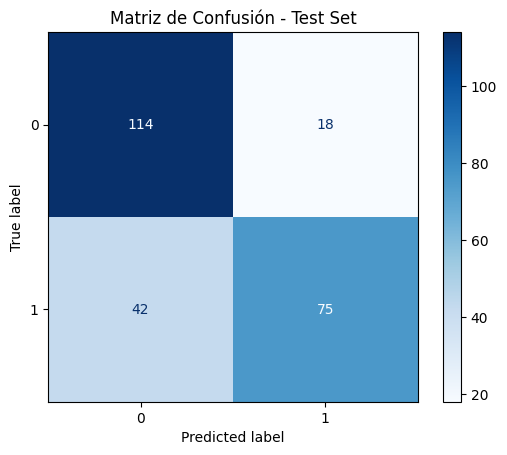

Accuracy en test: 0.759
Evaluación fit en test: Buen ajuste: desempeño similar en train y validación


In [94]:
# --- Evaluar en test ---
y_test_pred = best_model.predict(X_test)
print("\nReporte en test set:")
print(classification_report(y_test, y_test_pred))

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Test Set")
plt.show()

# --- Evaluar fit en test ---
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Accuracy en test: {test_acc:.3f}")
print("Evaluación fit en test:", evaluar_fit(best_row['train_accuracy'], test_acc))